## Ising Samples

In [1]:
%matplotlib inline
import numpy as np
from matplotlib import pyplot as plt
import matplotlib.animation as animation

class BoundaryCondition:
    RBC, PBC = range(2)
    
class Direction:
    RIGHT, TOP, LEFT, BOTTOM = range(4)
    
class Ising(object):
    
    def __init__ (self, L, J, T):
      
        self.L = L
        self.N = L*L
        self.TWOJ = 2.*J
        self.T = T
        self.beta = 1./T
        
        # Initialize site positions
        # Initialize neighbors table for boundary conditions
        self.nn = np.zeros(shape=(self.N,4), dtype=np.int16)
        self.position = np.zeros(shape=(L,L), dtype=np.int16)
        self.x = np.zeros(self.N, dtype=np.int16)
        self.y = np.zeros(self.N, dtype=np.int16)

        # Periodic boundary conditions
        n = 0
        for iy in range(L):
            for ix in range(L):
                self.position[iy,ix] = n
                self.x[n] = ix
                self.y[n] = iy
                self.nn[n,Direction.LEFT] = n-1
                self.nn[n,Direction.RIGHT] = n+1
                self.nn[n,Direction.TOP] = n+L
                self.nn[n,Direction.BOTTOM] = n-L
                if(ix == 0):
                    self.nn[n,Direction.LEFT] = n+L-1
                if(ix == L-1):
                    self.nn[n,Direction.RIGHT] = n-(L-1)
                if(iy == 0):
                    self.nn[n, Direction.BOTTOM] = n+(L-1)*L
                if(iy == L-1):
                    self.nn[n, Direction.TOP] = n-(L-1)*L
                n += 1

        # Initialize spins
        r = np.random.random(self.N)*2-1
        self.spin = np.ones(self.N, dtype=np.int16)
        for i in range(self.N):
            if(r[i] < 0):
                self.spin[i] *= -1
                
        self.Mtot = np.sum(self.spin)
        self.E = 0.
        for i in range(self.N):
            self.E += -J*self.spin[i]*(self.spin[self.nn[i,Direction.RIGHT]]+self.spin[self.nn[i,Direction.TOP]])

        # Transition probabilities
        self.de = np.zeros(shape=(3,9)) # spins -1 and 1 only, but choose 3 to index as below. 9 = range of spin_sum, -4 . . . 4
        self.w = np.zeros(shape=(3,9))
        self.set_temp(self.T)
                                                             
    def set_temp(self, T):
        self.T = T
        self.beta = 1./T
        # Lookup tables for transition probabilities
        for spin_sum in range(-4,5):
            self.de[0,spin_sum+4] = -self.TWOJ*spin_sum
            self.de[2,spin_sum+4] = self.TWOJ*spin_sum
            p = np.exp(-self.beta*self.de[0,spin_sum+4])
            self.w[0,spin_sum+4] = min(p, 1.)
            self.w[2,spin_sum+4] = min(1./p,1.)
                                                             
    def metropolis(self):
        nchanges = 0
        if True: # for n in range(self.N):
            # trial spin change
            # pick a random particle
            i = int(np.random.random()*self.N)

            # change in energy
            iright = self.nn[i, Direction.LEFT]
            ileft = self.nn[i, Direction.RIGHT]
            itop = self.nn[i, Direction.TOP]
            ibottom = self.nn[i, Direction.BOTTOM]

            spin_sum = self.spin[ileft] + self.spin[iright] + self.spin[itop] + self.spin[ibottom]

            s = self.spin[i]
            deltaE = self.de[s+1,spin_sum+4]

            # accept if lowers energy or random num below w
            if(deltaE <= 0. or np.random.random() < self.w[s+1,spin_sum+4]):
                self.spin[i] *= -1
                self.Mtot += 2*(-s)
                self.E += deltaE
                nchanges += 1

        return nchanges

    def spin_list_to_spin_matrix(self):
        return self.spin.reshape((self.L, self.L))
    
    def plot_state(self):
        pyplot.imshow(self.spin_list_to_spin_matrix(), cmap='gray', vmin=-1, vmax=1)
        pyplot.axis('off')
        pyplot.show()

        



In [2]:
L=10
Nwarmup = 1000
Nsteps = 10000
Ndecorr = 3
Temp = .00001 # Ordered Phase
# Temp = 2.6 # Critical Point
# Temp = 100. # Disordered Phase
J = 1.

S = Ising(L, J, Temp)
E = np.zeros(Nsteps)
M = np.zeros(Nsteps)

for i in range(Nwarmup):
    S.metropolis()

naccept = 0
states = []
for i in range(Nsteps):
    for n in range(Ndecorr):
        naccept += S.metropolis()
        # append clones self.spin_list_to_spin_matrix()
        states.append(S.spin_list_to_spin_matrix().copy())

# shuffle the states 
np.random.shuffle(states)

print("Number of states", len(states))


Number of states 30000


/var/folders/13/4h_rwpc12q15_80s7fq2msnw0000gp/T/ipykernel_85441/1839148702.py:76: RuntimeWarning: divide by zero encountered in scalar divide
  self.w[2,spin_sum+4] = min(1./p,1.)
/var/folders/13/4h_rwpc12q15_80s7fq2msnw0000gp/T/ipykernel_85441/1839148702.py:74: RuntimeWarning: overflow encountered in exp
  p = np.exp(-self.beta*self.de[0,spin_sum+4])


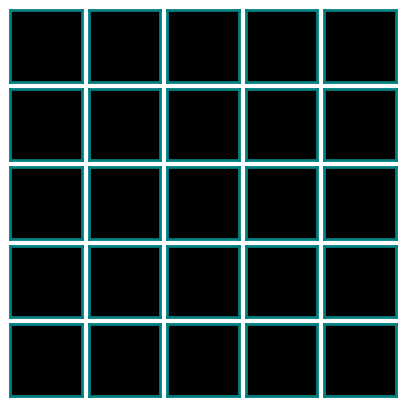

In [3]:
# plot the first 25 states in a 5 x 5 grid 
fig, axs = plt.subplots(5, 5, figsize=(4, 4))
for i in range(5):
    for j in range(5):
        axs[i, j].imshow(states[i*5 + j], cmap='gray', vmin=-1, vmax=1)
        axs[i, j].set_xticks([])
        axs[i, j].set_yticks([])
# add teal borders between configs 
for ax in axs.flat:
    for spine in ax.spines.values():
        spine.set_edgecolor('teal')
        spine.set_linewidth(2)
plt.tight_layout(pad=0.5)
plt.show()

## Implement Forward Diffusion Process

prompt to agent (Sonnet 4.5): explain the forward diffusion process in 2 paragraphs so that I can understand it better, and then apply it to my Ising states.

In [4]:
def create_noise_schedule(T, schedule_type='linear', beta_start=0.0001, beta_end=0.02):
    """
    Create a noise schedule for the diffusion process.
    
    Args:
        T: Number of diffusion timesteps
        schedule_type: 'linear' or 'cosine'
        beta_start: Starting noise level
        beta_end: Ending noise level
    
    Returns:
        betas: Noise schedule
        alphas: 1 - betas
        alpha_bars: Cumulative product of alphas
    """
    if schedule_type == 'linear':
        betas = np.linspace(beta_start, beta_end, T)
    elif schedule_type == 'cosine':
        # Cosine schedule from "Improved Denoising Diffusion Probabilistic Models"
        s = 0.008
        steps = np.arange(T + 1)
        alpha_bars = np.cos(((steps / T) + s) / (1 + s) * np.pi / 2) ** 2
        alpha_bars = alpha_bars / alpha_bars[0]
        betas = 1 - (alpha_bars[1:] / alpha_bars[:-1])
        betas = np.clip(betas, 0, 0.999)
    
    alphas = 1 - betas
    alpha_bars = np.cumprod(alphas)
    
    return betas, alphas, alpha_bars

def forward_diffusion(x0, t, alpha_bars):
    """
    Apply forward diffusion to a clean sample x0 at timestep t.
    
    Args:
        x0: Clean data (Ising state), shape (L, L)
        t: Timestep (0 to T-1)
        alpha_bars: Cumulative product of alphas
    
    Returns:
        xt: Noisy version at timestep t
        noise: The noise that was added
    """
    # Generate random Gaussian noise
    noise = np.random.randn(*x0.shape)
    
    # Apply the forward diffusion formula
    sqrt_alpha_bar = np.sqrt(alpha_bars[t])
    sqrt_one_minus_alpha_bar = np.sqrt(1 - alpha_bars[t])
    
    xt = sqrt_alpha_bar * x0 + sqrt_one_minus_alpha_bar * noise
    
    return xt, noise

# Create noise schedule
T = 1000  # Number of diffusion steps
betas, alphas, alpha_bars = create_noise_schedule(T, schedule_type='linear')

print(f"Created noise schedule with {T} timesteps")
print(f"Beta range: {betas[0]:.6f} to {betas[-1]:.6f}")
print(f"Alpha_bar range: {alpha_bars[0]:.6f} to {alpha_bars[-1]:.6f}")


Created noise schedule with 1000 timesteps
Beta range: 0.000100 to 0.020000
Alpha_bar range: 0.999900 to 0.000040


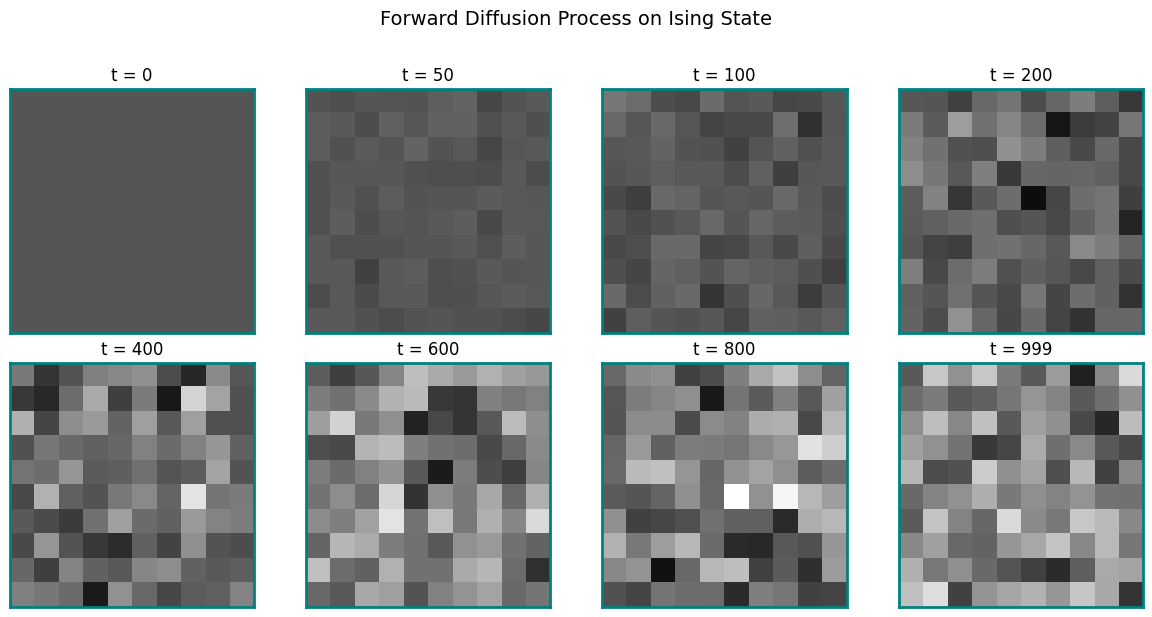

In [5]:
# Visualize the forward diffusion process on a single Ising state
# Select one clean state
clean_state = states[0]

# Apply diffusion at different timesteps
timesteps = [0, 50, 100, 200, 400, 600, 800, 999]
diffused_states = []

for t in timesteps:
    if t == 0:
        diffused_states.append(clean_state)
    else:
        xt, _ = forward_diffusion(clean_state, t, alpha_bars)
        diffused_states.append(xt)

# Plot the diffusion process
fig, axs = plt.subplots(2, 4, figsize=(12, 6))
axs = axs.flatten()

for idx, (t, state) in enumerate(zip(timesteps, diffused_states)):
    axs[idx].imshow(state, cmap='gray', vmin=-3, vmax=3)
    axs[idx].set_title(f't = {t}')
    axs[idx].set_xticks([])
    axs[idx].set_yticks([])
    for spine in axs[idx].spines.values():
        spine.set_edgecolor('teal')
        spine.set_linewidth(2)

plt.suptitle('Forward Diffusion Process on Ising State', fontsize=14, y=1.02)
plt.tight_layout()
plt.show()


In [6]:
# Create a dataset of noisy training pairs
# For each clean state, we'll sample a random timestep and create the noisy version
# This is what we'll use to train the denoising network

def create_diffusion_training_data(clean_states, alpha_bars, num_samples=None):
    """
    Create training pairs (noisy_state, timestep, noise) from clean states.
    
    Args:
        clean_states: List of clean Ising configurations
        alpha_bars: Cumulative noise schedule
        num_samples: Number of training samples to create (None = use all states)
    
    Returns:
        noisy_states: Array of noisy states
        timesteps: Array of timesteps used
        noises: Array of noise that was added (this is what the network will learn to predict)
    """
    if num_samples is None:
        num_samples = len(clean_states)
    
    T = len(alpha_bars)
    noisy_states = []
    timesteps = []
    noises = []
    
    for i in range(num_samples):
        # Pick a random clean state
        clean_state = clean_states[i % len(clean_states)]
        
        # Pick a random timestep
        t = np.random.randint(0, T)
        
        # Apply forward diffusion
        noisy_state, noise = forward_diffusion(clean_state, t, alpha_bars)
        
        noisy_states.append(noisy_state)
        timesteps.append(t)
        noises.append(noise)
    
    return np.array(noisy_states), np.array(timesteps), np.array(noises)

# Create some training samples
num_training_samples = 1000
noisy_states, timesteps_used, noises = create_diffusion_training_data(
    states[:num_training_samples], alpha_bars, num_training_samples
)

print(f"Created {num_training_samples} training samples")
print(f"Noisy states shape: {noisy_states.shape}")
print(f"Timesteps range: {timesteps_used.min()} to {timesteps_used.max()}")
print(f"Noise values range: {noises.min():.3f} to {noises.max():.3f}")


Created 1000 training samples
Noisy states shape: (1000, 10, 10)
Timesteps range: 3 to 998
Noise values range: -4.005 to 4.370


## Learning to Denoise

Prompt to Ask (Sonnet 4.5): explain to me in 2-3 paragraphs the basics of reversing the diffusion process. How do we learn to denoise, using neural networks?

(after explanation)

Prompt to Agent (Sonnet 4.5): Makes sense. Implement it for me. Use PyTorch and a score based generative model.

(it gave WAY too much code, that had too many bells and whistles, and didn't run).

Prompt to Agent (Sonnet 4.5): Simplify the code. Just give me a minimal working example that runs, and that I can understand.

In [7]:
import torch
import torch.nn as nn
import torch.nn.functional as F

print(f"PyTorch version: {torch.__version__}")
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")

PyTorch version: 2.9.1
Using device: cpu


In [8]:
# Simple neural network to predict noise
class SimpleNoisePredictor(nn.Module):
    def __init__(self, img_size=10):
        super().__init__()
        # Just a few convolutional layers - nothing fancy
        self.conv1 = nn.Conv2d(2, 32, 3, padding=1)  # 2 channels: image + time embedding
        self.conv2 = nn.Conv2d(32, 32, 3, padding=1)
        self.conv3 = nn.Conv2d(32, 1, 3, padding=1)  # Output: predicted noise
        
    def forward(self, x, t):
        # x: (batch, 1, H, W) - the noisy image
        # t: (batch,) - timestep as a number between 0 and 1
        
        # Create a simple time embedding: a constant grid filled with the timestep value
        batch_size = x.shape[0]
        t_grid = t.view(batch_size, 1, 1, 1).expand(-1, 1, x.shape[2], x.shape[3])
        
        # Concatenate image with time embedding
        x_with_time = torch.cat([x, t_grid], dim=1)
        
        # Simple feedforward through conv layers
        h = F.relu(self.conv1(x_with_time))
        h = F.relu(self.conv2(h))
        noise_pred = self.conv3(h)
        
        return noise_pred

# Create the model
model = SimpleNoisePredictor(img_size=L).to(device)
print(f"Model has {sum(p.numel() for p in model.parameters()):,} parameters")

Model has 10,145 parameters


In [9]:
# Prepare training data
# Convert to PyTorch tensors
X_train = torch.FloatTensor(noisy_states[:1000]).unsqueeze(1)  # Add channel dimension
t_train = torch.FloatTensor(timesteps_used[:1000]) / T  # Normalize timesteps to [0, 1]
noise_train = torch.FloatTensor(noises[:1000]).unsqueeze(1)

print(f"Training data shapes:")
print(f"  Noisy images: {X_train.shape}")
print(f"  Timesteps: {t_train.shape}")
print(f"  Target noise: {noise_train.shape}")

Training data shapes:
  Noisy images: torch.Size([1000, 1, 10, 10])
  Timesteps: torch.Size([1000])
  Target noise: torch.Size([1000, 1, 10, 10])


Training...
Epoch 1/100, Loss: 0.5522
Epoch 1/100, Loss: 0.5522
Epoch 2/100, Loss: 0.1837
Epoch 2/100, Loss: 0.1837
Epoch 3/100, Loss: 0.1464
Epoch 3/100, Loss: 0.1464
Epoch 4/100, Loss: 0.1266
Epoch 4/100, Loss: 0.1266
Epoch 5/100, Loss: 0.1086
Epoch 5/100, Loss: 0.1086
Epoch 6/100, Loss: 0.0932
Epoch 6/100, Loss: 0.0932
Epoch 7/100, Loss: 0.0806
Epoch 7/100, Loss: 0.0806
Epoch 8/100, Loss: 0.0696
Epoch 8/100, Loss: 0.0696
Epoch 9/100, Loss: 0.0611
Epoch 9/100, Loss: 0.0611
Epoch 10/100, Loss: 0.0546
Epoch 10/100, Loss: 0.0546
Epoch 11/100, Loss: 0.0499
Epoch 11/100, Loss: 0.0499
Epoch 12/100, Loss: 0.0464
Epoch 12/100, Loss: 0.0464
Epoch 13/100, Loss: 0.0434
Epoch 13/100, Loss: 0.0434
Epoch 14/100, Loss: 0.0409
Epoch 14/100, Loss: 0.0409
Epoch 15/100, Loss: 0.0387
Epoch 15/100, Loss: 0.0387
Epoch 16/100, Loss: 0.0368
Epoch 16/100, Loss: 0.0368
Epoch 17/100, Loss: 0.0352
Epoch 17/100, Loss: 0.0352
Epoch 18/100, Loss: 0.0337
Epoch 18/100, Loss: 0.0337
Epoch 19/100, Loss: 0.0324
Epoch 1

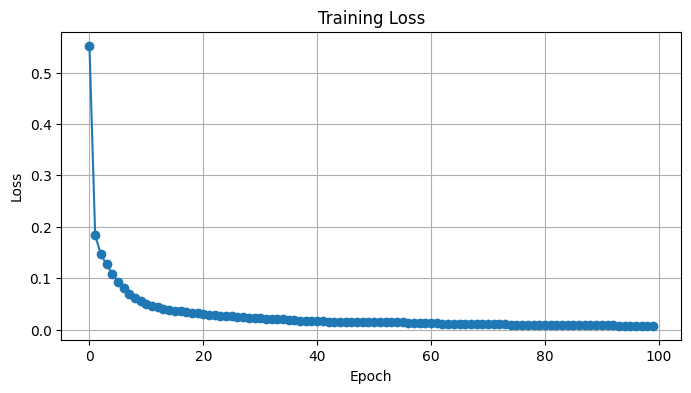

In [10]:
# Simple training loop
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

losses = []
batch_size = 32
n_epochs = 100

print("Training...")
for epoch in range(n_epochs):
    epoch_loss = 0
    n_batches = 0
    
    # Simple batch training
    for i in range(0, len(X_train), batch_size):
        # Get batch
        batch_x = X_train[i:i+batch_size].to(device)
        batch_t = t_train[i:i+batch_size].to(device)
        batch_noise = noise_train[i:i+batch_size].to(device)
        
        # Forward pass: predict the noise
        pred_noise = model(batch_x, batch_t)
        
        # Loss: how well did we predict the noise?
        loss = F.mse_loss(pred_noise, batch_noise)
        
        # Backward pass
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        epoch_loss += loss.item()
        n_batches += 1
    
    avg_loss = epoch_loss / n_batches
    losses.append(avg_loss)
    print(f"Epoch {epoch+1}/{n_epochs}, Loss: {avg_loss:.4f}")

print("\nTraining done!")

# Plot loss
plt.figure(figsize=(8, 4))
plt.plot(losses, marker='o')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training Loss')
plt.grid(True)
plt.show()

Generating new Ising configurations...


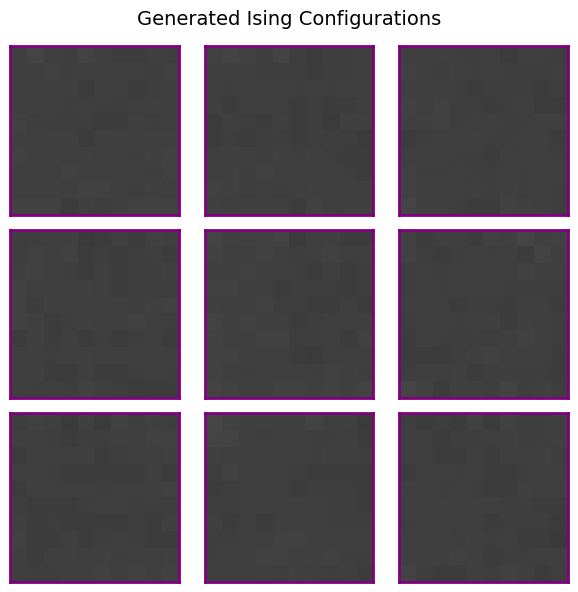

In [11]:
# Generate new samples!
@torch.no_grad()
def generate_sample(model, img_size, n_timesteps, betas, alphas, alpha_bars):
    """
    Start with random noise and gradually denoise it to create a new Ising configuration.
    """
    model.eval()
    
    # Start with pure random noise
    x = torch.randn(1, 1, img_size, img_size).to(device)
    
    # Convert numpy arrays to torch tensors
    betas_t = torch.FloatTensor(betas).to(device)
    alphas_t = torch.FloatTensor(alphas).to(device)
    alpha_bars_t = torch.FloatTensor(alpha_bars).to(device)
    
    # Gradually remove noise, step by step
    for t in reversed(range(n_timesteps)):
        # Normalize timestep to [0, 1] for the model
        t_normalized = torch.FloatTensor([t / n_timesteps]).to(device)
        
        # Ask the model: what noise is in this image?
        predicted_noise = model(x, t_normalized)
        
        # Remove the predicted noise
        alpha = alphas_t[t]
        alpha_bar = alpha_bars_t[t]
        beta = betas_t[t]
        
        # Denoising formula
        x = (x - (beta / torch.sqrt(1 - alpha_bar)) * predicted_noise) / torch.sqrt(alpha)
        
        # Add a little random noise (except at the very end)
        if t > 0:
            noise = torch.randn_like(x)
            x = x + torch.sqrt(beta) * noise
    
    return x.cpu().numpy()[0, 0]

# Generate a few samples
print("Generating new Ising configurations...")
generated = [generate_sample(model, L, T, betas, alphas, alpha_bars) for _ in range(9)]

# Show them
fig, axs = plt.subplots(3, 3, figsize=(6, 6))
for i in range(3):
    for j in range(3):
        axs[i, j].imshow(generated[i*3 + j], cmap='gray', vmin=-2, vmax=2)
        axs[i, j].set_xticks([])
        axs[i, j].set_yticks([])
        for spine in axs[i, j].spines.values():
            spine.set_edgecolor('purple')
            spine.set_linewidth(2)

plt.suptitle('Generated Ising Configurations', fontsize=14)
plt.tight_layout()
plt.show()

In [12]:
print(np.round(generated[0]))
print(states[0])

[[-1. -1. -1. -1. -1. -1. -1. -1. -1. -1.]
 [-1. -1. -1. -1. -1. -1. -1. -1. -1. -1.]
 [-1. -1. -1. -1. -1. -1. -1. -1. -1. -1.]
 [-1. -1. -1. -1. -1. -1. -1. -1. -1. -1.]
 [-1. -1. -1. -1. -1. -1. -1. -1. -1. -1.]
 [-1. -1. -1. -1. -1. -1. -1. -1. -1. -1.]
 [-1. -1. -1. -1. -1. -1. -1. -1. -1. -1.]
 [-1. -1. -1. -1. -1. -1. -1. -1. -1. -1.]
 [-1. -1. -1. -1. -1. -1. -1. -1. -1. -1.]
 [-1. -1. -1. -1. -1. -1. -1. -1. -1. -1.]]
[[-1 -1 -1 -1 -1 -1 -1 -1 -1 -1]
 [-1 -1 -1 -1 -1 -1 -1 -1 -1 -1]
 [-1 -1 -1 -1 -1 -1 -1 -1 -1 -1]
 [-1 -1 -1 -1 -1 -1 -1 -1 -1 -1]
 [-1 -1 -1 -1 -1 -1 -1 -1 -1 -1]
 [-1 -1 -1 -1 -1 -1 -1 -1 -1 -1]
 [-1 -1 -1 -1 -1 -1 -1 -1 -1 -1]
 [-1 -1 -1 -1 -1 -1 -1 -1 -1 -1]
 [-1 -1 -1 -1 -1 -1 -1 -1 -1 -1]
 [-1 -1 -1 -1 -1 -1 -1 -1 -1 -1]]


[[-1 -1 -1 -1 -1 -1 -1 -1 -1 -1]
 [-1 -1 -1 -1 -1 -1 -1 -1 -1 -1]
 [-1 -1 -1 -1 -1 -1 -1 -1 -1 -1]
 [-1 -1 -1 -1 -1 -1 -1 -1 -1 -1]
 [-1 -1 -1 -1 -1 -1 -1 -1 -1 -1]
 [-1 -1 -1 -1 -1 -1 -1 -1 -1 -1]
 [-1 -1 -1 -1 -1 -1 -1 -1 -1 -1]
 [-1 -1 -1 -1 -1 -1 -1 -1 -1 -1]
 [-1 -1 -1 -1 -1 -1 -1 -1 -1 -1]
 [-1 -1 -1 -1 -1 -1 -1 -1 -1 -1]]
[[-1 -1 -1 -1 -1 -1 -1 -1 -1 -1]
 [-1 -1 -1 -1 -1 -1 -1 -1 -1 -1]
 [-1 -1 -1 -1 -1 -1 -1 -1 -1 -1]
 [-1 -1 -1 -1 -1 -1 -1 -1 -1 -1]
 [-1 -1 -1 -1 -1 -1 -1 -1 -1 -1]
 [-1 -1 -1 -1 -1 -1 -1 -1 -1 -1]
 [-1 -1 -1 -1 -1 -1 -1 -1 -1 -1]
 [-1 -1 -1 -1 -1 -1 -1 -1 -1 -1]
 [-1 -1 -1 -1 -1 -1 -1 -1 -1 -1]
 [-1 -1 -1 -1 -1 -1 -1 -1 -1 -1]]
[[-1 -1 -1 -1 -1 -1 -1 -1 -1 -1]
 [-1 -1 -1 -1 -1 -1 -1 -1 -1 -1]
 [-1 -1 -1 -1 -1 -1 -1 -1 -1 -1]
 [-1 -1 -1 -1 -1 -1 -1 -1 -1 -1]
 [-1 -1 -1 -1 -1 -1 -1 -1 -1 -1]
 [-1 -1 -1 -1 -1 -1 -1 -1 -1 -1]
 [-1 -1 -1 -1 -1 -1 -1 -1 -1 -1]
 [-1 -1 -1 -1 -1 -1 -1 -1 -1 -1]
 [-1 -1 -1 -1 -1 -1 -1 -1 -1 -1]
 [-1 -1 -1 -1 -1 -1 -1 -1 -1 -1]]
[[-1 -1

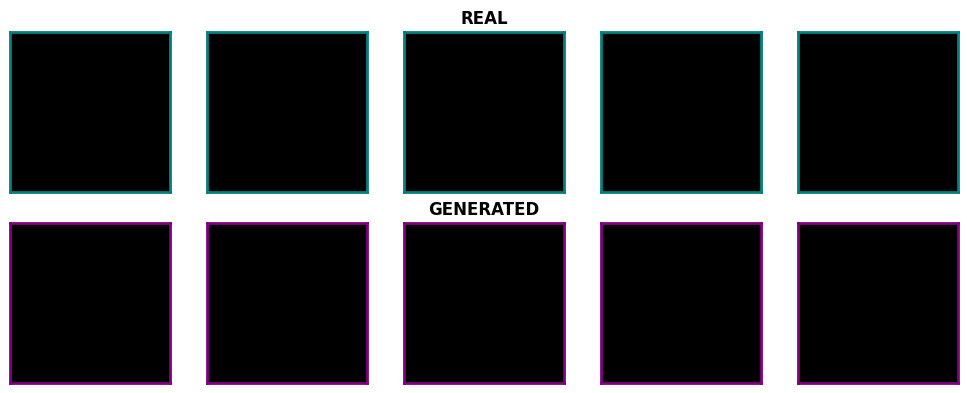

In [13]:
# Compare: Real vs Generated
fig, axs = plt.subplots(2, 5, figsize=(10, 4))

rounded_generated = [np.round(g) for g in generated]

# Top row: Real Ising configurations from simulation
for i in range(5):
    axs[0, i].imshow(states[i], cmap='gray', vmin=-1, vmax=1)
    print(states[i])
    axs[0, i].set_xticks([])
    axs[0, i].set_yticks([])
    if i == 2:
        axs[0, i].set_title('REAL', fontweight='bold')
    for spine in axs[0, i].spines.values():
        spine.set_edgecolor('teal')
        spine.set_linewidth(2)

# Bottom row: Generated by diffusion model
for i in range(5):
    axs[1, i].imshow(rounded_generated[i], cmap='gray', vmin=-1, vmax=1)
    print(rounded_generated[i])
    axs[1, i].set_xticks([])
    axs[1, i].set_yticks([])
    if i == 2:
        axs[1, i].set_title('GENERATED', fontweight='bold')
    for spine in axs[1, i].spines.values():
        spine.set_edgecolor('purple')
        spine.set_linewidth(2)

plt.tight_layout()
plt.show()

Generating denoising trajectories...


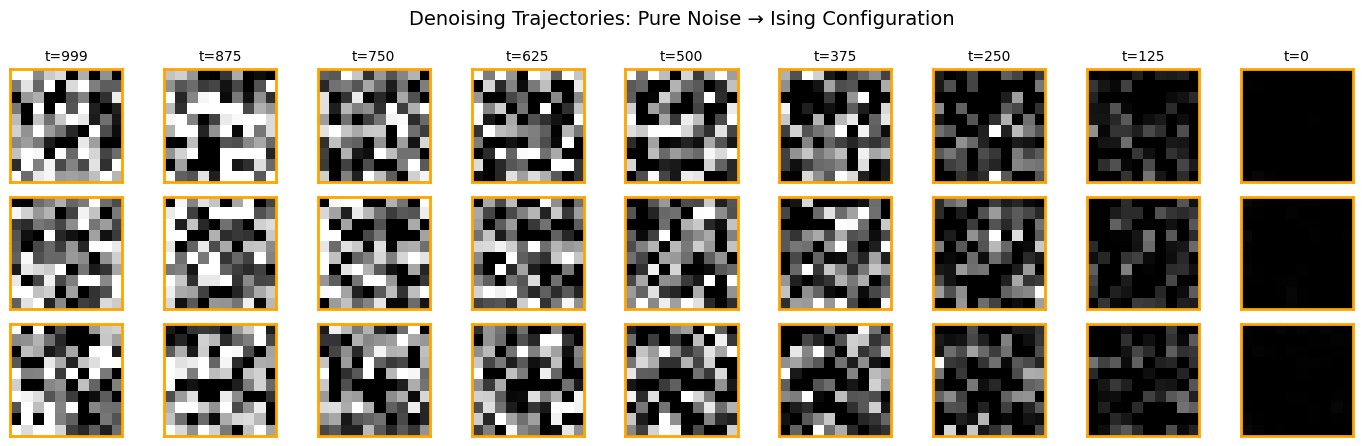


Showing 9 snapshots from the denoising process
Watch how random noise gradually transforms into ordered spin configurations!


In [14]:
# Show the denoising trajectory - how noise becomes structure
@torch.no_grad()
def generate_with_trajectory(model, img_size, n_timesteps, betas, alphas, alpha_bars, save_every=100):
    """
    Generate a sample and save intermediate steps to visualize the denoising process.
    """
    model.eval()
    
    # Start with pure random noise
    x = torch.randn(1, 1, img_size, img_size).to(device)
    
    # Convert to torch tensors
    betas_t = torch.FloatTensor(betas).to(device)
    alphas_t = torch.FloatTensor(alphas).to(device)
    alpha_bars_t = torch.FloatTensor(alpha_bars).to(device)
    
    # Save the trajectory
    trajectory = [(n_timesteps - 1, x.cpu().numpy()[0, 0].copy())]
    
    # Gradually remove noise
    for t in reversed(range(n_timesteps)):
        t_normalized = torch.FloatTensor([t / n_timesteps]).to(device)
        predicted_noise = model(x, t_normalized)
        
        alpha = alphas_t[t]
        alpha_bar = alpha_bars_t[t]
        beta = betas_t[t]
        
        x = (x - (beta / torch.sqrt(1 - alpha_bar)) * predicted_noise) / torch.sqrt(alpha)
        
        if t > 0:
            noise = torch.randn_like(x)
            x = x + torch.sqrt(beta) * noise
        
        # Save snapshots along the way
        if t % save_every == 0 or t == 0:
            trajectory.append((t, x.cpu().numpy()[0, 0].copy()))
    
    return trajectory

# Generate multiple trajectories
print("Generating denoising trajectories...")
n_trajectories = 3
trajectories = [generate_with_trajectory(model, L, T, betas, alphas, alpha_bars, save_every=125) 
                for _ in range(n_trajectories)]

# Plot the trajectories
fig, axs = plt.subplots(n_trajectories, len(trajectories[0]), figsize=(14, 4.5))

for traj_idx in range(n_trajectories):
    for step_idx, (t, state) in enumerate(trajectories[traj_idx]):
        ax = axs[traj_idx, step_idx] if n_trajectories > 1 else axs[step_idx]
        ax.imshow(state, cmap='gray', vmin=-1, vmax=1)
        ax.set_xticks([])
        ax.set_yticks([])
        
        # Title only on top row
        if traj_idx == 0:
            ax.set_title(f't={t}', fontsize=10)
        
        # Add orange borders
        for spine in ax.spines.values():
            spine.set_edgecolor('orange')
            spine.set_linewidth(2)

plt.suptitle('Denoising Trajectories: Pure Noise → Ising Configuration', fontsize=14, y=0.98)
plt.tight_layout()
plt.show()

print(f"\nShowing {len(trajectories[0])} snapshots from the denoising process")
print("Watch how random noise gradually transforms into ordered spin configurations!")

# Caveats

We see that this is working remarkably well. You can rerun with different temperatures, as I did; see the values above for the critical temperature and the disordered phase. 

However, it's also a simple model and a simple distribution. We should learn a little bit about potential improvements, and the idea of score-based generative models.

Prompt to Ask (Sonnet 4.5): Analyze this code. Give me a bulleted list (with BRIEF explanations) of potential caveats in applying this simple model in more complicated settings. Then explain to me in a paragraph the basics of score based generative models.

Answer:

#### Caveats for More Complex Settings

**Architecture Limitations:**
- **Simple time embedding**: Just concatenating a scalar timestep value won't scale well - complex data needs sinusoidal positional encodings or learned embeddings
- **Shallow network**: Only 3 conv layers can't capture complex hierarchical features - real applications use U-Nets with skip connections, attention mechanisms, or transformers
- **No residual connections**: Without skip connections, gradients vanish in deeper networks and training becomes unstable

**Data & Training Issues:**
- **Small dataset**: 1000 samples works for simple Ising configs but won't generalize to high-dimensional distributions - you'd need millions of samples for images
- **Limited diversity**: Training on a single temperature means the model only learns one phase - it won't work across different physical regimes
- **Fixed noise schedule**: Linear schedule isn't optimal for all data - images often need cosine schedules, and the β range needs careful tuning per application

**Sampling Efficiency:**
- **1000 denoising steps**: This is slow! Real applications use DDIM (fewer steps), classifier-free guidance, or learned samplers to generate in 10-50 steps
- **No variance preservation**: The simple denoising formula can lead to sample quality degradation - better samplers use variance-preserving formulations

**Domain-Specific Challenges:**
- **Continuous vs discrete**: Your Ising spins are discrete (±1) but the model generates continuous values that need rounding - this breaks differentiability for some applications
- **Boundary conditions**: Periodic boundaries are baked into your Ising data, but the model doesn't explicitly respect this symmetry
- **Mode collapse**: For multimodal distributions (e.g., mixed phases), simple models might fail to capture all modes

#### Score-Based Generative Models

Score-based generative models provide an elegant theoretical framework that unifies diffusion models with the concept of the "score function" - the gradient of the log probability density $\nabla_x \log p(x)$. Instead of predicting noise directly, these models learn to estimate the score at different noise levels, which tells you which direction to move in data space to increase probability. The connection is beautiful: predicting noise $\epsilon_\theta$ and predicting the score $s_\theta$ are equivalent up to scaling, since $\nabla_x \log p(x_t) = -\epsilon/\sigma_t$. The advantage of the score-based perspective is that it enables powerful techniques like score matching (training without explicit density estimation), annealed Langevin dynamics (gradual denoising with temperature schedules), and probability flow ODEs (deterministic sampling paths). This framework also connects diffusion to stochastic differential equations (SDEs), where forward diffusion is a noise-adding SDE and reverse diffusion solves the reverse-time SDE using learned scores, enabling more sophisticated samplers and theoretical guarantees about convergence to the true data distribution.